# 0. Introduction

This notebook demonstrates the key series representation and generalized shot-noise representation techniques for simulating Subordinator, Normal-Variance-Mean (NVM) Lévy processes (infinite activity examples) and State-Space models (SSM) used in our paper [^1].


## Contents
1. Simulation Examples of Subordinator Lévy Processes
2. Simulation of NVM Processes
3. Simulation of Lévy SSM


[^1]: B. Z. Lin and S. Godsill. Bayesian Non-Parametric Inference for Lévy Measures in State-Space Models. (arXiv:2505.22587), May 2025. arXiv:2505.22587 [stat]


## Modules and Random Seed

We import the necessary modules and also fix the random seed in the following block. Feel free to change the seed. To get more random behaviour, just run the sub block for more times.

In [1]:
import os
import random
import numpy as np
#Fixing the random seed
SEED = 42               # ← change once and everything follows
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
import matplotlib.pyplot as plt
from Levy_Generators import *
from tqdm import tqdm
from Common_Tools import *
from Levy_State_Space import *
from scipy.stats import gamma


# 1. Subordinator Process Simulation

Simulation of Lévy processes is often difficult due to the challenges of intractable likelihood or infinite activity. For subordinator processes, they generally need truncation in their series representation to finite activity for simulation [^1]. In this section, we demonstrate first the Gamma process, which is known to have infinite activity but known likelihood, for the power of this approach due to the known ground truth. Then, we apply this method to the more difficult tempered stable process that is known to have both intractable likelihood and infinite activity, and will be used frequently in our latter experiments. The algorithms come from [^2].


[^1]: R. Cont and P. Tankov. Financial Modelling with Jump Processes. Chapman & Hall/CRC Financial Mathematics Series. Chapman & Hall/CRC, Boca Raton, Fla., 2004.

[^2]: Y. Kındap and S. J. Godsill. Point Process Simulation of Generalised Hyperbolic Le ́vy Processes. Statistics and Computing, 34(1):33, 2024.

## 1.1 Gamma Process Simulation and Verification

### Simulation of Gamma Process Jump Series and then Path

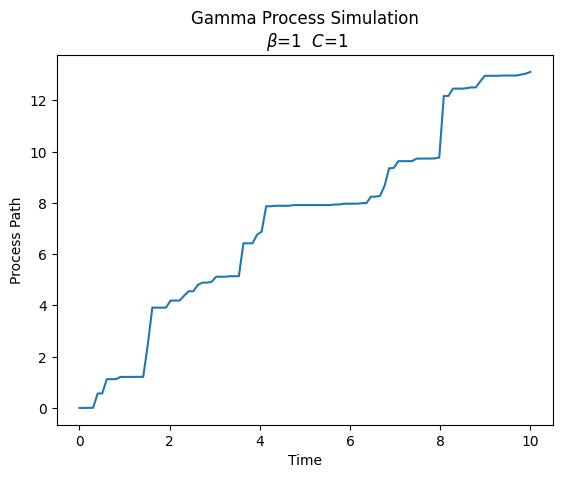

In [2]:
#Define the time axis first for the random process to be generated
T = 10.0
time_axis = np.linspace(0,T,int(T)*10) #Can be arbitray, not necessarily regularly spaced

#Define the Gamma Process Parameters
beta=1 #Rate
C=1 #Shape

#Simulate to get the jump series representation of the process
jump_sizes,jump_times = gamma_process_jumps((beta,C),T,sim_rate=200) 

#Integrate the series representation to path for visualization
process_path = integrate_to_path(jump_sizes,jump_times,time_axis)

plt.figure()
plt.plot(time_axis,process_path[0,:])
plt.xlabel("Time")
plt.ylabel("Process Path")
plt.title(f"Gamma Process Simulation\n $\\beta$={beta}  $C$={C}")
plt.show()


### Verification of the Simulator by Collecting Path Values at t=1 and Comparing to the Ground-Truth Distributions

Progress: 100%|██████████| 3/3 [00:20<00:00,  6.98s/it]


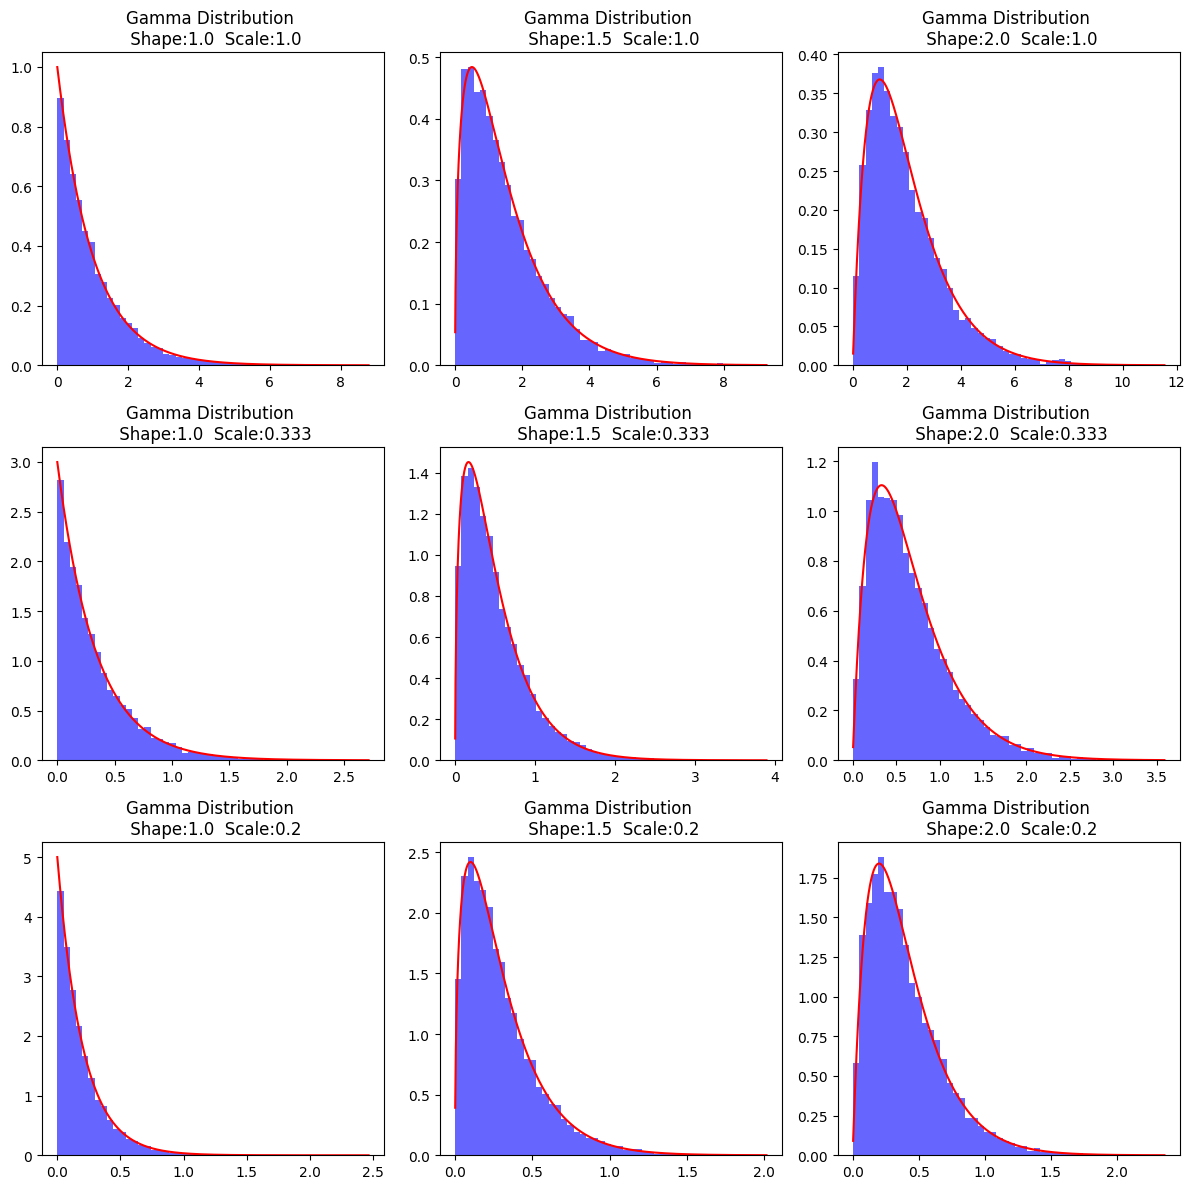

In [3]:
N = 10000 #The number of samples for the empirical distribution
T = 2.0
beta_series = np.linspace(1,5,3)
alpha_series = 1/beta_series  #Convert to scale for scioy convention
C_series = np.linspace(1,2,3)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in tqdm(range(len(alpha_series)),desc = "Progress"):
    for j in range(len(C_series)):
        C = C_series[j]
        alpha = alpha_series[i]
        beta = beta_series[i]
        samples = []
        #Take samples at time t=1 to check if the empirical distirbution matches the gamma distribution with the corresponding parameters
        for k in range(N): 
            jump_sizes,jump_times = gamma_process_jumps((beta,C),T,sim_rate=200)
            sample = integrate_to_path(jump_sizes,jump_times,[1.0]) #Evaluate the path at t=1
            samples.append(sample[0,0])
        axes[i,j].hist(samples, bins=50, density=True, alpha=0.6, color='b', label="Gamma Process Samples")
        
        # Generate x values
        x = np.linspace(min(samples), max(samples), 1000)
        
        # Plotting gamma distribution
        axes[i,j].plot(x, gamma.pdf(x, C, scale=alpha), 'r', label="Gamma Distribution")
        axes[i,j].set_title(f"Gamma Distribution \n Shape:{round(C,3)}  Scale:{round(alpha,3)}")

plt.tight_layout()
plt.show()

## 1.2 Tempered Stable Process Simulation
The tempered stable process is defined as an alpha-stable process with exponential tempering. The Gamma process can be obtained with the alpha parameter tending to 0.

It is very difficult to verify the generator at this stage. We will evidence its validty empirically using the inference results in the other notebook. For now, we may assume that it is valid from the accuracy of the Gamma process generator.

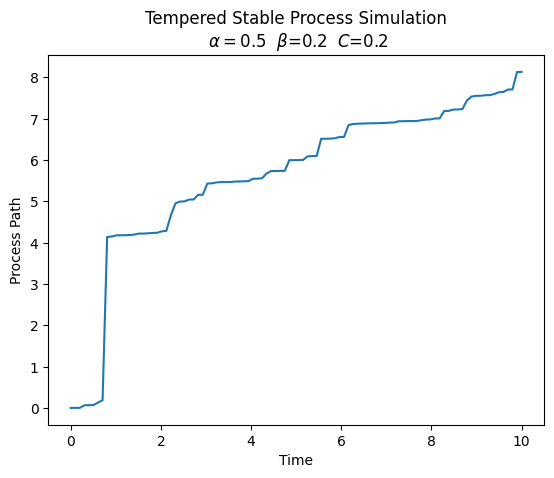

In [4]:
#Define again the time axis
T = 10.0
time_axis = np.linspace(0,T,int(T)*10)

#Define the parameters, now with an additional alpha parameter
beta=0.2
alpha = 0.5
C=0.2

#Generate again the jump sizes and times, the series representation
jump_sizes,jump_times = tempered_stable_process_jumps((beta,alpha,C),T)

#Integrate the series to path for visualization
process_path = integrate_to_path(jump_sizes,jump_times,time_axis)
plt.figure()
plt.plot(time_axis,process_path[0,:])
plt.xlabel("Time")
plt.ylabel("Process Path")
plt.title(f"Tempered Stable Process Simulation\n $\\alpha = {alpha}$  $\\beta$={beta}  $C$={C}")
plt.show()

# 2. NVM Process Simulation

The NVM process is also called the time-changed Brownian motion, that is using the subordinator process as the time axis for the Brownian motion [^1]. The stochastic volatility model is a special case of this approach. This class of methods explains the heavy-tailed behaviour in the original time domain using a larger time span in the time-changed domain.

This time-change or subordination mechanism introduces only more complexity to the simulation and likelihoods, but as demonstrated in our paper, the series representation for the subordinator processes can be used to obtain that for the NVM process, which can be used for simulation.


[^1]: P. Carr and L. Wu. Time-Changed Lévy Processes and Option Pricing. Journal of Financial Economics, 71(1):113–141, January 2004.

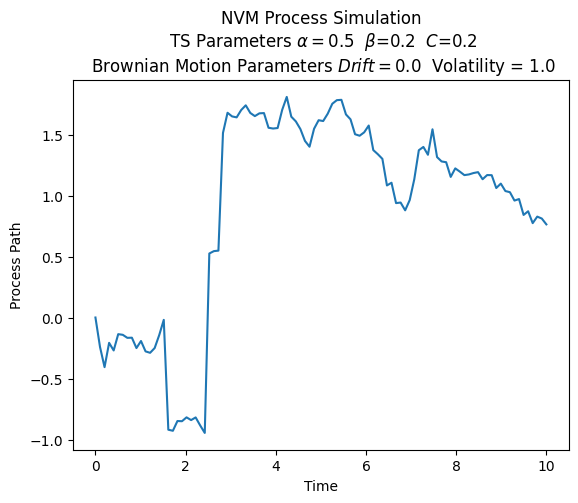

In [5]:
#Define again the time axis
T = 10.0
time_axis = np.linspace(0,T,int(T)*10)

#Define now the Brownian motion parameters
muw = 0.0
sigmaw = 1.0

# Generate the series representation from the tempered stable subordinator process.
beta=0.2
alpha = 0.5
C=0.2
jump_sizes,jump_times = tempered_stable_process_jumps((beta,alpha,C),T)

#Obtain the NVM process series representation. Note that the jump times are inherited, and we only need the jump sizes.
nvm_jump_sizes = nvm_process_jumps(jump_sizes,muw,sigmaw)

#Integrate again to process paths for visualization
process_path = integrate_to_path(nvm_jump_sizes,jump_times,time_axis)
plt.figure()
plt.plot(time_axis,process_path[0,:])
plt.xlabel("Time")
plt.ylabel("Process Path")
plt.title(f"NVM Process Simulation\n TS Parameters $\\alpha = {alpha}$  $\\beta$={beta}  $C$={C} \n Brownian Motion Parameters $Drift = {muw}$  Volatility = {sigmaw}")
plt.show()

# 3. Simulation of Lévy SSM

Finally, we may feed the series representation of the Lévy processes into a SSM, to get the generalized shot-noise representation of the SSM response [^1].

[^1]: M. Tapia Costa, I. Kontoyiannis, and S. J. Godsill. Generalised Shot Noise Representations of Stochastic Systems Driven by Non-Gaussian Lévy Processes. arXiv preprint, arXiv:2305.05931, 2023.


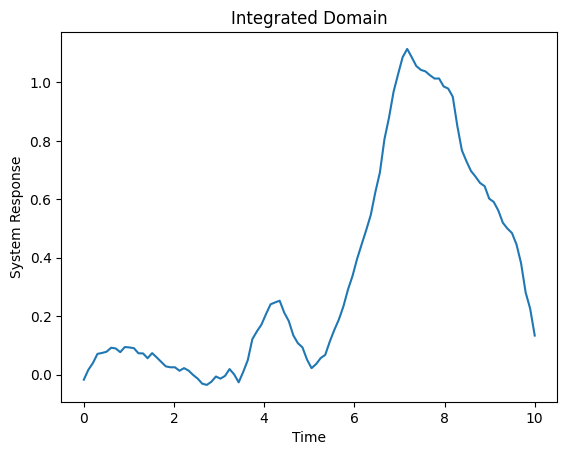

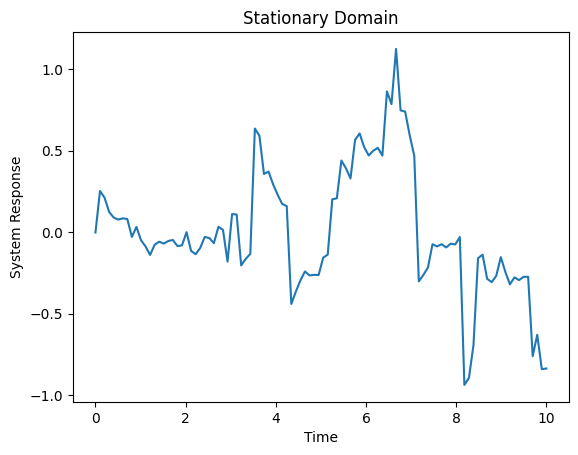

In [6]:
#Partially Observed Model
observation_noise_level = 0.0001

#Define again the time axis
T = 10.0
time_axis = np.linspace(0,T,int(T)*10)

#Define the Brownian motion parameters
muw = 0.0
sigmaw = 1.0

#Define and simulate the subordinator process
beta=0.2
alpha = 0.5
C=0.2
sub_jump_sizes,jump_times = tempered_stable_process_jumps((beta,alpha,C),T)

#Generate the NVM process
nvm_jump_sizes = nvm_process_jumps(sub_jump_sizes,muw,sigmaw)

#Define the system parameter and obtain the generalized shot-noise representation
theta = -1.0
langevin_path = langevin_hidden_response(nvm_jump_sizes,jump_times,theta,time_axis) #(2,N) process path
noisy_langevin_path = langevin_observations(langevin_path,observation_noise_level*np.identity(2))
x_path = noisy_langevin_path[0,:]
xdot_path = noisy_langevin_path[1,:]

plt.figure()
plt.plot(time_axis,x_path)
plt.ylabel("System Response")
plt.xlabel("Time")
plt.title("Integrated Domain")
plt.show()


plt.figure()
plt.plot(time_axis,xdot_path)
plt.ylabel("System Response")
plt.xlabel("Time")
plt.title("Stationary Domain")
plt.show()